In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import svm

In [2]:
dest = pd.read_csv('destinations.csv',nrows=10000)
dest.shape

(10000, 150)

In [3]:
df = pd.read_csv('train.csv',nrows=10000)
df.shape

(10000, 24)

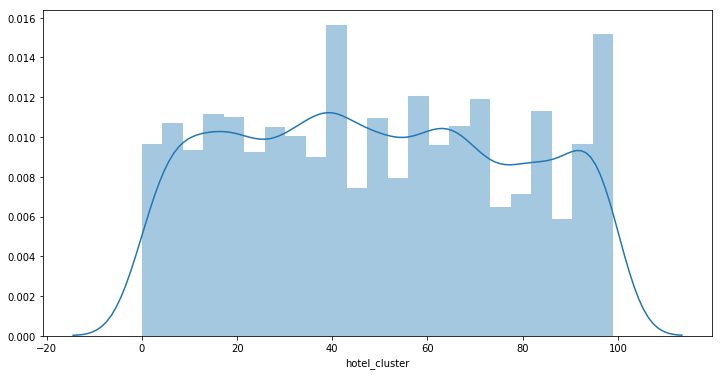

In [4]:
plt.figure(figsize=(12, 6))
sns.distplot(df['hotel_cluster'])

In [5]:
from datetime import datetime
def get_year(x):
    if x is not None and type(x) is not float:
        try:
            return datetime.strptime(x, '%Y-%m-%d').year
        except ValueError:
            return datetime.strptime(x, '%Y-%m-%d %H:%M:%S').year
    else:
        return 2013
    pass
def get_month(x):
    if x is not None and type(x) is not float:
        try:
            return datetime.strptime(x, '%Y-%m-%d').month
        except:
            return datetime.strptime(x, '%Y-%m-%d %H:%M:%S').month
    else:
        return 1
    pass
    
def left_merge_dataset(left_dframe, right_dframe, merge_column):
    return pd.merge(left_dframe, right_dframe, on=merge_column, how='left')

In [6]:
df['date_time_year'] = pd.Series(df.date_time, index = df.index)
df['date_time_month'] = pd.Series(df.date_time, index = df.index)
from datetime import datetime
df.date_time_year = df.date_time_year.apply(lambda x: get_year(x))
df.date_time_month = df.date_time_month.apply(lambda x: get_month(x))
del df['date_time']

In [7]:
df['srch_ci_year'] = pd.Series(df.srch_ci, index=df.index)
df['srch_ci_month'] = pd.Series(df.srch_ci, index=df.index)
# convert year & months to int
df.srch_ci_year = df.srch_ci_year.apply(lambda x: get_year(x))
df.srch_ci_month = df.srch_ci_month.apply(lambda x: get_month(x))
# remove the srch_ci column
del df['srch_ci']

In [8]:
df['srch_co_year'] = pd.Series(df.srch_co, index=df.index)
df['srch_co_month'] = pd.Series(df.srch_co, index=df.index)
# convert year & months to int
df.srch_co_year = df.srch_co_year.apply(lambda x: get_year(x))
df.srch_co_month = df.srch_co_month.apply(lambda x: get_month(x))
# remove the srch_co column
del df['srch_co']

In [9]:
df.corr()["hotel_cluster"].sort_values()

srch_destination_type_id    -0.058900
hotel_country               -0.044418
user_id                     -0.038995
site_name                   -0.026337
date_time_month             -0.024503
hotel_continent             -0.019589
srch_destination_id         -0.018666
is_booking                  -0.010207
srch_co_year                -0.004266
is_mobile                   -0.002428
cnt                         -0.002255
user_location_country       -0.000625
srch_ci_year                -0.000551
date_time_year              -0.000369
srch_rm_cnt                  0.001093
srch_ci_month                0.001621
srch_adults_cnt              0.003635
user_location_city           0.008353
srch_co_month                0.008463
channel                      0.010784
orig_destination_distance    0.012138
srch_children_cnt            0.015038
hotel_market                 0.021549
posa_continent               0.022083
user_location_region         0.031275
is_package                   0.068721
hotel_cluste

In [10]:
pieces = [df.groupby(['srch_destination_id','hotel_country','hotel_market','hotel_cluster'])['is_booking'].agg(['sum','count'])]
agg = pd.concat(pieces).groupby(level=[0,1,2,3]).sum()
agg.dropna(inplace=True)
agg.head()

sum  count
srch_destination_id hotel_country hotel_market hotel_cluster            
11                  50            824          94               1      2
16                  50            419          7                1      2
19                  102           1522         20               0      1
                                               30               0      1
                                               40               0      4

In [11]:
agg['sum_and_cnt'] = 0.85*agg['sum'] + 0.15*agg['count']
agg = agg.groupby(level=[0,1,2]).apply(lambda x: x.astype(float)/x.sum())
agg.reset_index(inplace=True)
agg.head()

,srch_destination_id,hotel_country,hotel_market,hotel_cluster,sum,count,sum_and_cnt
0,11,50,824,94,1.0,1.000000,1.000000
1,16,50,419,7,1.0,1.000000,1.000000
2,19,102,1522,20,NaN,0.142857,0.142857
3,19,102,1522,30,NaN,0.142857,0.142857
4,19,102,1522,40,NaN,0.571429,0.571429


In [12]:
agg_pivot = agg.pivot_table(index=['srch_destination_id','hotel_country','hotel_market'], columns='hotel_cluster', values='sum_and_cnt').reset_index()
agg_pivot.head()

hotel_cluster,srch_destination_id,hotel_country,hotel_market,0,1,2,3,4,5,6,...,90,91,92,93,94,95,96,97,98,99
0,11,50,824,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,16,50,419,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,19,102,1522,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,56,77,217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,66,50,423,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
df = pd.merge(df, dest, how='left', on='srch_destination_id')
df = pd.merge(df, agg_pivot, how='left', on=['srch_destination_id','hotel_country','hotel_market'])
df.fillna(0, inplace=True)
df.shape

(10000, 276)

In [14]:
df = df.loc[df['is_booking'] == 1]

In [15]:
X = df.drop(['is_booking'], axis=1)
y = df.hotel_cluster

In [16]:
X['user_id']

1          12
20        756
27       1048
72       1048
79       1482
81       1482
83       1482
128      1713
133      1713
137      2140
158      2451
268      2451
276      2451
306      2451
331      2451
351      2451
352      2451
372      3313
401      3313
408      3925
410      3925
412      3925
414      3925
418      3925
425      3925
599      3972
601      3972
604      3972
606      3972
746      4413
        ...  
9528    53865
9542    53865
9546    53865
9559    53865
9560    53865
9566    53865
9575    53865
9582    54043
9604    54043
9620    54043
9635    54043
9637    54043
9658    54043
9661    54043
9684    54075
9693    54107
9696    54163
9698    54163
9715    54163
9721    54163
9731    54163
9893    54163
9908    54163
9939    54163
9942    54163
9946    54163
9953    54163
9964    54163
9974    54163
9991    54261
Name: user_id, Length: 777, dtype: int64

In [17]:
X['hotel_cluster']

1        1
20       2
27      58
72      36
79      95
81      95
83      95
128     38
133     81
137     43
158     25
268     10
276     99
306     78
331      8
351     15
352     15
372     91
401     54
408     42
410     42
412     32
414      7
418     83
425     18
599     18
601     18
604     95
606     95
746     12
        ..
9528    54
9542    16
9546    11
9559    21
9560    82
9566    42
9575    63
9582    29
9604    29
9620    29
9635    29
9637    46
9658    59
9661    28
9684    25
9693    57
9696    91
9698    95
9715    84
9721    16
9731    25
9893    52
9908    48
9939    41
9942    28
9946    28
9953    28
9964    33
9974    72
9991    52
Name: hotel_cluster, Length: 777, dtype: int64

In [22]:
X_test_hotel = X[3:4]['hotel_cluster']
X_test_user = X[3:4]['user_id']
X = X.tail(62)
print(X_test_hotel)
print(X_test_user)

9194    68
Name: hotel_cluster, dtype: int64
9194    52846
Name: user_id, dtype: int64


In [23]:
y_test = y.head(1)
y = y.tail(62)

In [24]:
from sklearn.naive_bayes import GaussianNB
clf = make_pipeline(preprocessing.StandardScaler(), GaussianNB(priors=None))
np.mean(cross_val_score(clf, X, y, cv=10))

ValueError: n_splits=10 cannot be greater than the number of members in each class.

In [23]:
from sklearn.neighbors import KNeighborsClassifier
clf = make_pipeline(preprocessing.StandardScaler(), KNeighborsClassifier(n_neighbors=5))
np.mean(cross_val_score(clf, X, y, cv=10, scoring='accuracy'))

c:\users\renuka\appdata\local\programs\python\python35\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
c:\users\renuka\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\renuka\appdata\local\programs\python\python35\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
c:\users\renuka\appdata\local\programs\python\python35\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 

0.33520784873335174

In [20]:
import pickle
clf = make_pipeline(preprocessing.StandardScaler(), svm.SVC(decision_function_shape='ovo'))
np.mean(cross_val_score(clf, X, y))
filename = 'svm_hotel.sav'
pickle.dump(clf,open(filename,'wb'))

c:\users\renuka\appdata\local\programs\python\python35\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
c:\users\renuka\appdata\local\programs\python\python35\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
c:\users\renuka\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\renuka\appdata\local\programs\python\python35\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dty

In [25]:
clf = make_pipeline(preprocessing.StandardScaler(), RandomForestClassifier(n_estimators=273,max_depth=10,random_state=0))
np.mean(cross_val_score(clf, X, y, cv=10))

c:\users\renuka\appdata\local\programs\python\python35\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
c:\users\renuka\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\renuka\appdata\local\programs\python\python35\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
c:\users\renuka\appdata\local\programs\python\python35\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 

0.30577212657495373

In [75]:
import pickle
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

clf.fit(X,y)
filename = 'lor_model.sav'
pickle.dump(clf,open(filename,'wb'))
print("Model Saved")

Model Saved


c:\users\renuka\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\renuka\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\users\renuka\appdata\local\programs\python\python35\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [24]:
import pickle
from sklearn import svm
clf = svm.SVC()
clf.fit(X,y)
filename = 'svm_hotel.sav'
pickle.dump(clf,open(filename,'wb'))

c:\users\renuka\appdata\local\programs\python\python35\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [31]:
test = X[3:4]
test

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,is_mobile,is_package,channel,srch_adults_cnt,...,90,91,92,93,94,95,96,97,98,99
9194,2,3,66,174,5938,2030.8356,0,1,9,1,...,0.0,0.002302,0.0,0.0,0.0,0.0,0.135073,0.0,0.0,0.0


In [32]:
# X.head(1).shape
y_pred = clf.predict(test)

In [33]:
y_pred

array([68], dtype=int64)

In [36]:
y_test = np.array(y[3:4])

In [37]:
y_test

array([68], dtype=int64)